# **SVRのパラメーターチューニングを行う**

### **必要な関数・ライブラリ**

In [40]:
# データ加工・処理・分析モジュール
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.externals import joblib

%matplotlib inline

In [2]:
def set_time(dataframe, col_name):
    '''
    to_datetimeを使うための前処理
    '''
    dataframe[col_name] = dataframe[col_name].map(lambda x : transform_time(x))
    return dataframe

In [3]:
def transform_time(x):
    '''
    set_time内で使う関数
    to_datetimeで24時をサポートしないので00に変更する処理
    '''
    str_x = str(x)
    res = ''
    if str(x)[8:10] == '24':
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' 00:'+str_x[10:12] 
    else:
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' '+ str_x[8:10] +':'+str_x[10:12]
    return res

In [4]:
def add_hour_month(input_data):
    '''
    時間や月のデータを加える
    '''
    input_data['hour'] = input_data['datetime'].map(lambda x: int(x.hour))
    input_data['minute'] = input_data['datetime'].map(lambda x: int(x.minute))
    input_data['month'] = input_data['datetime'].map(lambda x: int(x.month))
    input_data['month_cos'] = input_data['month'].map(lambda x: np.cos(np.pi * x / 12))
    input_data['month_sin'] = input_data['month'].map(lambda x: np.sin(np.pi * x / 12))
    input_data['hour_cos'] = input_data['hour'].map(lambda x: np.cos(np.pi * x / 24))
    input_data['hour_sin'] = input_data['hour'].map(lambda x: np.sin(np.pi * x / 24))
    input_data = input_data.drop(['hour', 'minute', 'month'], axis=1)
    return input_data

In [5]:
def get_30(tmp_data):
    '''
    必要なカラムだけ拾ってきて30分ごのデータに整形
    '''
    tmp_data = tmp_data[["datetime", "pr", "max_ws", "ave_ws", "max_tp", "min_tp", "sl"]]
    
    # 欠損値を一つ前の値で置換/output_data
    tmp_data = tmp_data.fillna(method='bfill')
    tmp_30 = tmp_data.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()

    # datetimeのカラムを復活させる
    tmp_30['datetime'] = tmp_30.index
    tmp_30.index = np.arange(len(tmp_30))
    tmp_30.head()
    return tmp_30

In [6]:
def add_time_data(input_data, key="datetime"):
    '''
    時間や月のデータを加える
    '''
    input_data['month'] = input_data[key].map(lambda x: int(x.month))
    input_data['month_cos'] = input_data['month'].map(lambda x: np.cos(np.pi * x / 12))
    input_data['month_sin'] = input_data['month'].map(lambda x: np.sin(np.pi * x / 12))
    input_data['hour'] = input_data[key].map(lambda x: int(x.month))
    input_data['hour_cos'] = input_data['hour'].map(lambda x: np.cos(np.pi * x / 24))
    input_data['hour_sin'] = input_data['hour'].map(lambda x: np.sin(np.pi * x / 24))
    input_data = input_data.drop(['month', 'hour'], axis=1)
    return input_data

In [7]:
def normalize_array(x):
    '''
    min, max, min-max正規化を行なった配列(np.array)を返す
    '''
    x = np.array(x)
    x_min = x.min()
    x_max = x.max()
    normalized = (x - x_min) / (x_max - x_min) 
    return x_min, x_max, normalized

In [8]:
def denormalize_array(normalized_x, x_min, x_max):
    '''
    正規化前のmin, maxを用いて元のスケールに戻す
    '''
    normalized_x = np.array(normalized_x)
    denormalize_array = (normalized_x) * (x_max - x_min) + x_min
    return denormalize_array

In [9]:
def drop_nan(X, Y):
    '''
    正解データがnanであるデータの組を削除
    '''
    mask = np.isnan(Y)
    X = X[~mask]
    Y = Y[~mask]
    return X, Y

In [10]:
def calc_mae(X, Y):
    '''
    X, Yがメモリを食いすぎるのでfor文で計算
    '''
    mse = 0
    for i in range(len(X)):
        mse += np.abs(X[i]- Y[i])
    return mse/len(X)

In [11]:
def scaling_output(output_30):
    '''
    直近2015年の総発電量に合わせて他の年の初で量も合わせる関数
    '''
    output_30['year'] = output_30['datetime'].map(lambda x : x.year)
    y_output = output_30.groupby(['year'], as_index=False).sum()
    sum_2012 = y_output["SOLA0"+str(target_place)][0]
    sum_2013 = y_output["SOLA0"+str(target_place)][1]
    sum_2014 = y_output["SOLA0"+str(target_place)][2]
    sum_2015 = y_output["SOLA0"+str(target_place)][3]
    scaled_2012 = np.array(output_30[output_30['year'] == 2012]["SOLA0"+str(target_place)].map(lambda x : x * sum_2015/sum_2012))
    scaled_2013 = np.array(output_30[output_30['year'] == 2013]["SOLA0"+str(target_place)].map(lambda x : x * sum_2015/sum_2013))
    scaled_2014 = np.array(output_30[output_30['year'] == 2014]["SOLA0"+str(target_place)].map(lambda x : x * sum_2015/sum_2014))
    scaled_2015 = np.array(output_30[output_30['year'] == 2015]["SOLA0"+str(target_place)])
    tmp = np.r_[scaled_2012, scaled_2013, scaled_2014, scaled_2015]
    output_30["SOLA0"+str(target_place)] = tmp
    
    return output_30

In [12]:
def wv_to_sin(x):
    '''
    漢字になってる風向データをsinになおす
    '''
    if x == "北":
        return -1.0
    elif x == "北西":
        return -0.5
    elif x == "西":
        return 0.0
    elif x == "南西":
        return 0.5
    elif x == "南":
        return 1.0
    elif x == "南東":
        return 0.5
    elif x == "東":
        return 0
    else:
        return -0.5

In [13]:
def wv_to_cos(x):
    '''
    漢字になってる風向データをcosになおす
    '''
    
    if x == "北":
        return 0.0
    elif x == "北西":
        return 0.5
    elif x == "西":
        return 1.0
    elif x == "南西":
        return 0.5
    elif x == "南":
        return 0.0
    elif x == "南東":
        return -0.5
    elif x == "東":
        return -1.0
    else:
        return -0.5

In [14]:
def extract_hours(output_30):
    '''
    決まった時間帯のみを予測するための関数
    '''
    output_30[ "hour"] = output_30["datetime"].map(lambda x : x.hour)
    output_30 = output_30[output_30["hour"] > 6]
    output_30 = output_30[output_30["hour"] < 20]
    output_30 = output_30.drop(["hour"], axis=1)
    return output_30

In [15]:
def minus_to_zero(x):
    if x < 0:
        return 0
    else:
        return x

### **データの準備**

In [16]:
target_place = 3

In [17]:
# 発電量データ
output_30 = pd.read_csv('data/processed_data/out_put.tsv', delimiter = '\t')
output_30['datetime'] = output_30['datetime'].map(lambda x : pd.to_datetime(x))
output_30 = output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30 = scaling_output(output_30)

In [18]:
# 天気予報のデータを実は今まで使ってなかった
if target_place == 1 or target_place == 2:
    fc_data = pd.read_csv('data/raw_data/forecast_kanagawa.tsv', delimiter = '\t')
    fc_data['date'] = fc_data['date'].map(lambda x : pd.to_datetime(x))
elif target_place == 3:
    fc_data = pd.read_csv('data/raw_data/forecast_yamanashi.tsv', delimiter = '\t')
    fc_data['date'] = fc_data['date'].map(lambda x : pd.to_datetime(x))
else:
    raise ValueError("invalid input target_place")

In [19]:
fc_data.columns

Index(['date', 'weather', 'weather_detail', 'wind', 'wave', 'pc_00-06',
       'pc_06-12', 'pc_12-18', 'pc_18-24', 'we_00-03', 'we_03-06', 'we_06-09',
       'we_09-12', 'we_12-15', 'we_15-18', 'we_18-21', 'we_21-24', 'wv_00-03',
       'wv_03-06', 'wv_06-09', 'wv_09-12', 'wv_12-15', 'wv_15-18', 'wv_18-21',
       'wv_21-24', 'wc_00-03', 'wc_03-06', 'wc_06-09', 'wc_09-12', 'wc_12-15',
       'wc_15-18', 'wc_18-21', 'wc_21-24', 'min_tp', 'max_tp', 'tp_00-03',
       'tp_03-06', 'tp_06-09', 'tp_09-12', 'tp_12-15', 'tp_15-18', 'tp_18-21',
       'tp_21-24'],
      dtype='object')

In [20]:
# 各データ期間のタイムスタンプを作成
# 学習＋評価期間：30分間隔
total_rng = pd.date_range("201201010000", "201703312330", freq="30T")

In [21]:
input_df= pd.DataFrame()
input_df["datetime"] = total_rng

In [22]:
# 3時間毎天気予報の追加
fc_weather = fc_data.loc[:,fc_data.columns.str.startswith("we_")]
fc_weather = fc_weather.values.flatten()
fc_weather = np.repeat(fc_weather, 6)
input_df["weather"] = fc_weather

# 3時間毎気温の追加
fc_weather = fc_data.loc[:,fc_data.columns.str.startswith("tp_")]
fc_weather = fc_weather.values.flatten()
fc_weather = np.repeat(fc_weather, 6)
input_df["tp"] = fc_weather

# 3時間毎風向の追加
fc_weather = fc_data.loc[:,fc_data.columns.str.startswith("wv_")]
fc_weather = fc_weather.values.flatten()
fc_weather = np.repeat(fc_weather, 6)
input_df["wv"] = fc_weather
input_df["wv_cos"] = input_df["wv"].map(lambda x : wv_to_cos(x))
input_df["wv_sin"] = input_df["wv"].map(lambda x : wv_to_sin(x))
input_df = input_df.drop(["wv"], axis=1)

# 3時間毎風速の追加
fc_weather = fc_data.loc[:,fc_data.columns.str.startswith("wc_")]
fc_weather = fc_weather.values.flatten()
fc_weather = np.repeat(fc_weather, 6)
input_df["wc"] = fc_weather

# 6時間毎降水確率の追加
fc_weather = fc_data.loc[:,fc_data.columns.str.startswith("pc_")]
fc_weather = fc_weather.values.flatten()
fc_weather = np.repeat(fc_weather, 12)
input_df["pc"] = fc_weather

In [23]:
input_df['month'] = input_df['datetime'].map(lambda x: str(x.month))
input_df['hour'] = input_df['datetime'].map(lambda x : str(x.hour))

In [24]:
# sincosのダミー変数は使わない
input_df = pd.get_dummies(input_df)

In [25]:
input_df.head()

,datetime,tp,wv_cos,wv_sin,wc,pc,weather_くもり,weather_晴れ,weather_雨,weather_雪,...,hour_21,hour_22,hour_23,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9
0,2012-01-01 00:00:00,1,0.5,0.5,2,10,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2012-01-01 00:30:00,1,0.5,0.5,2,10,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2012-01-01 01:00:00,1,0.5,0.5,2,10,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2012-01-01 01:30:00,1,0.5,0.5,2,10,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2012-01-01 02:00:00,1,0.5,0.5,2,10,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# モデル構築のためにデータを分割する
wfc_data = input_df

# 学習に必要なデータ
# 前日の気象予報のデータで翌日の0:00 ~ 23:30を予測する
train_x_s_idx = wfc_data[wfc_data['datetime'] == pd.to_datetime('2012-01-01 00:00')].index[0]
train_x_e_idx = wfc_data[wfc_data['datetime'] == pd.to_datetime('2015-12-31 23:30')].index[0]
train_y_s_idx = output_30[output_30['datetime'] == pd.to_datetime('2012-01-01 00:00')].index[0]
train_y_e_idx = output_30[output_30['datetime'] == pd.to_datetime('2015-12-31 23:30')].index[0]

# 決まった時間帯のみを予測する
# output_kwh = output_30[train_y_s_idx:train_y_e_idx+1]
# output_kwh = extract_hours(output_kwh)["SOLA0"+str(target_place)]
# input_data = wfc_data[train_x_s_idx:train_x_e_idx+1]
# input_data = extract_hours(input_data).drop(["datetime"], axis=1)

output_kwh = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
input_data = wfc_data.drop(["datetime"], axis=1)[train_x_s_idx:train_x_e_idx+1]

# 予測に必要なデータ
# 前日の00:00 ~ 20:00のデータで翌日の0:00 ~ 23:30を予測する
test_x_s_idx = wfc_data[wfc_data["datetime"] == pd.to_datetime('2016-01-01 00:00')].index[0]
test_x_e_idx = wfc_data[wfc_data["datetime"] == pd.to_datetime('2017-3-31 23:30')].index[0]

# 決まった時間のみを予測する
# test_input_data = wfc_data[test_x_s_idx:test_x_e_idx+1]
# test_input_data = extract_hours(test_input_data).drop(["datetime"], axis=1)

test_input_data = wfc_data.drop(["datetime"], axis=1)[test_x_s_idx:test_x_e_idx+1]

In [27]:
# min-max正規化しておく
normalized_input = (input_data - input_data.min()) / (input_data.max() - input_data.min())
normalized_input = normalized_input.dropna(axis=1)
normalized_input = np.array(normalized_input)
normalized_kwh = (output_kwh) /( output_kwh.max())
normalized_kwh = np.array(normalized_kwh)

input_list = normalized_input
kwh_list =normalized_kwh

X, Y = drop_nan(input_list, kwh_list)

# testデータの入力を用意
normalized_test_input = (test_input_data - test_input_data.min()) / (test_input_data.max() - test_input_data.min())
normalized_test_input = normalized_test_input.dropna(axis=1)
normalized_test_input = np.array(normalized_test_input)

X_test = normalized_test_input

# denormalize用
kwh_max = float(output_kwh.max())
kwh_min = 0

In [28]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.3)))

### **とりあえず発電しない時間帯を除かない状態でやってます**

### **SVR**

In [29]:
from sklearn.svm import SVR

### **カーネルトリック無しだと思ってたらデフォルトがrbfでした**

In [32]:
# 最適なepsilonを決めたい
C = 0.01
t_maes = []
v_maes = []
epsilons = [0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
for epsilon in epsilons:
    svr = SVR(C=C, epsilon=epsilon)
    svr.fit(X_train, Y_train) 

    Y_train_pred = svr.predict(X_train)
    Y_train_pred = denormalize_array(Y_train_pred, kwh_min, kwh_max)
    Y_train_true = denormalize_array(Y_train, kwh_min, kwh_max)

    Y_val_pred = svr.predict(X_val)
    Y_val_pred = denormalize_array(Y_val_pred, kwh_min, kwh_max)
    Y_val_true = denormalize_array(Y_val, kwh_min, kwh_max)
    
    t_maes.append(np.abs(Y_train_pred - Y_train_true).mean())
    v_maes.append(np.abs(Y_val_pred - Y_val_true).mean())
#     print("train_mae : ", np.abs(Y_train_pred - Y_train_true).mean())
#     print("val_mae : ", np.abs(Y_val_pred - Y_val_true).mean())

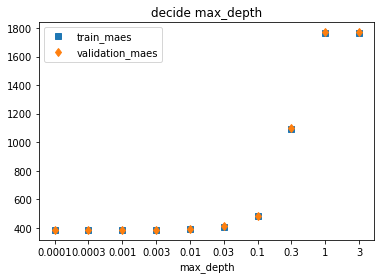

In [35]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.xticks(np.arange(len(epsilons)), epsilons)
plt.xlabel("epsilon")
plt.title("decide epsilon")
plt.legend()

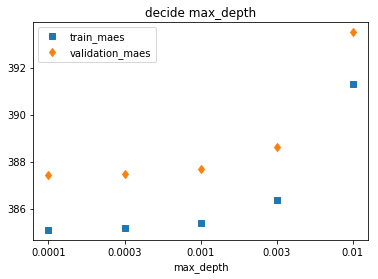

In [38]:
plt.plot(t_maes[:-5], 's', label="train_maes")
plt.plot(v_maes[:-5], 'd', label="validation_maes")
plt.xticks(np.arange(len(epsilons)-5), epsilons[:-5])
plt.xlabel("epsilon")
plt.title("decide epsilon")
plt.legend()

In [39]:
# 最適なCを決めたい
Cs = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3]
t_maes = []
v_maes = []
for C in Cs:
    svr = SVR(C=C, epsilon=0.001)
    svr.fit(X_train, Y_train) 

    Y_train_pred = svr.predict(X_train)
    Y_train_pred = denormalize_array(Y_train_pred, kwh_min, kwh_max)
    Y_train_true = denormalize_array(Y_train, kwh_min, kwh_max)

    Y_val_pred = svr.predict(X_val)
    Y_val_pred = denormalize_array(Y_val_pred, kwh_min, kwh_max)
    Y_val_true = denormalize_array(Y_val, kwh_min, kwh_max)
    
    t_maes.append(np.abs(Y_train_pred - Y_train_true).mean())
    v_maes.append(np.abs(Y_val_pred - Y_val_true).mean())
#     print("train_mae : ", np.abs(Y_train_pred - Y_train_true).mean())
#     print("val_mae : ", np.abs(Y_val_pred - Y_val_true).mean())

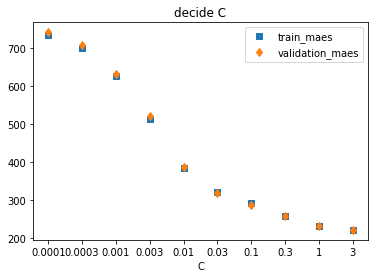

In [41]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.xticks(np.arange(len(epsilons)), epsilons)
plt.xlabel("C")
plt.title("decide C")
plt.legend()

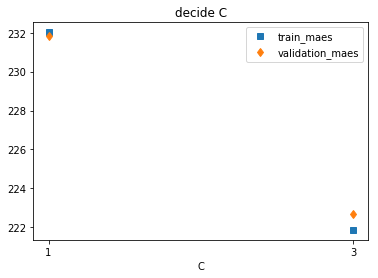

In [44]:
plt.plot(t_maes[7:], 's', label="train_maes")
plt.plot(v_maes[7:], 'd', label="validation_maes")
plt.xticks(np.arange(len(epsilons)-8), epsilons[8:])
plt.xlabel("C")
plt.title("decide C")
plt.legend()

In [45]:
# 最適なepsilonを決めたい(続く)
C = 3
t_maes = []
v_maes = []
epsilons = [0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
for epsilon in epsilons:
    svr = SVR(C=C, epsilon=epsilon)
    svr.fit(X_train, Y_train) 

    Y_train_pred = svr.predict(X_train)
    Y_train_pred = denormalize_array(Y_train_pred, kwh_min, kwh_max)
    Y_train_true = denormalize_array(Y_train, kwh_min, kwh_max)

    Y_val_pred = svr.predict(X_val)
    Y_val_pred = denormalize_array(Y_val_pred, kwh_min, kwh_max)
    Y_val_true = denormalize_array(Y_val, kwh_min, kwh_max)
    
    t_maes.append(np.abs(Y_train_pred - Y_train_true).mean())
    v_maes.append(np.abs(Y_val_pred - Y_val_true).mean())
#     print("train_mae : ", np.abs(Y_train_pred - Y_train_true).mean())
#     print("val_mae : ", np.abs(Y_val_pred - Y_val_true).mean())

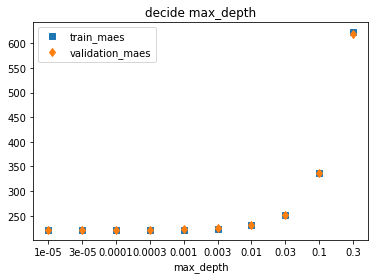

In [46]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.xticks(np.arange(len(epsilons)), epsilons)
plt.xlabel("max_depth")
plt.title("decide max_depth")
plt.legend()

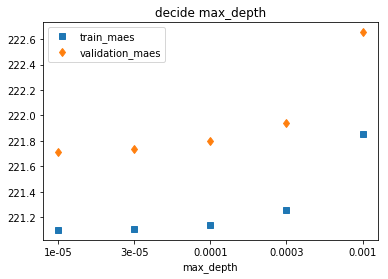

In [49]:
plt.plot(t_maes[:-5], 's', label="train_maes")
plt.plot(v_maes[:-5], 'd', label="validation_maes")
plt.xticks(np.arange(len(epsilons)-5), epsilons[:-5])
plt.xlabel("max_depth")
plt.title("decide max_depth")
plt.legend()

In [37]:
# 最適なCを決めたい(続く)
Cs = [1, 3, 10, 30, 100]
t_maes = []
v_maes = []
for C in Cs:
    svr = SVR(C=C, epsilon=0.001, max_iter = 10000)
    svr.fit(X_train, Y_train) 

    Y_train_pred = svr.predict(X_train)
    Y_train_pred = denormalize_array(Y_train_pred, kwh_min, kwh_max)
    Y_train_true = denormalize_array(Y_train, kwh_min, kwh_max)

    Y_val_pred = svr.predict(X_val)
    Y_val_pred = denormalize_array(Y_val_pred, kwh_min, kwh_max)
    Y_val_true = denormalize_array(Y_val, kwh_min, kwh_max)
    
    t_maes.append(np.abs(Y_train_pred - Y_train_true).mean())
    v_maes.append(np.abs(Y_val_pred - Y_val_true).mean())
#     print("train_mae : ", np.abs(Y_train_pred - Y_train_true).mean())
#     print("val_mae : ", np.abs(Y_val_pred - Y_val_true).mean())

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


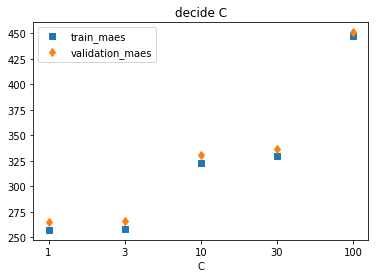

In [42]:
plt.plot(t_maes[:], 's', label="train_maes")
plt.plot(v_maes[:], 'd', label="validation_maes")
plt.xticks(np.arange(len(Cs)), Cs)
plt.xlabel("C")
plt.title("decide C")
plt.legend()

### とりあえずC= 3, epsilon = 0.00001を最適としておきます

In [44]:
svr = SVR(C=3, epsilon=0.00001)
svr.fit(X_train, Y_train) 

Y_train_pred = svr.predict(X_train)
Y_train_pred = denormalize_array(Y_train_pred, kwh_min, kwh_max)
Y_train_true = denormalize_array(Y_train, kwh_min, kwh_max)

Y_val_pred = svr.predict(X_val)
Y_val_pred = denormalize_array(Y_val_pred, kwh_min, kwh_max)
Y_val_true = denormalize_array(Y_val, kwh_min, kwh_max)

print("train mae :", np.abs(Y_train_pred - Y_train_true).mean())
print("validation mae : ", np.abs(Y_val_pred - Y_val_true).mean())

train mae : 219.044554855
validation mae :  226.845133986


In [48]:
'''
# 交差検証
t_maes = []
v_maes = []

n_splits = 5
C = 3
epsilon = 0.00001
i = 0
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    
    X_train = X[train_idx]
    Y_train = Y[train_idx]
    X_val = X[test_idx]
    Y_val = Y[test_idx]
    
    svr = SVR(C=C, epsilon=epsilon)
    svr.fit(X_train, Y_train)
    
    i += 1
    model_name = "target_place_"+str(target_place)+"_svr_C_"+str(C)
    model_name +="_e_"+str(epsilon)+"_"+str(i)+"-"+str(n_splits)+"folds"
    model_name += ".pkl"
    
    Y_train_pred = svr.predict(X_train)
    Y_train_pred = denormalize_array(Y_train_pred, kwh_min, kwh_max)
    Y_train_true = denormalize_array(Y_train, kwh_min, kwh_max)

    Y_val_pred = svr.predict(X_val)
    Y_val_pred = denormalize_array(Y_val_pred, kwh_min, kwh_max)
    Y_val_true = denormalize_array(Y_val, kwh_min, kwh_max)
    
    joblib.dump(svr, "data/model/"+model_name) 
    
    t_maes.append(np.abs(Y_train_pred - Y_train_true).mean())
    v_maes.append(np.abs(Y_val_pred - Y_val_true).mean())
    
    print(str(i)+"-"+str(n_splits)+" folds")
    print("train mae :", np.abs(Y_train_pred - Y_train_true).mean())
    print("validation mae : ", np.abs(Y_val_pred - Y_val_true).mean())
    print()
'''
# 下のmaeはscaleを戻してないから大きくめいているだけです

1-5 folds
train mae : 796.050209842
validation mae :  866.083701904

2-5 folds
train mae : 809.213919143
validation mae :  735.925150721

3-5 folds
train mae : 731.415126152
validation mae :  794.566442231

4-5 folds
train mae : 742.906887214
validation mae :  841.100854145

5-5 folds
train mae : 799.698078482
validation mae :  671.14647115



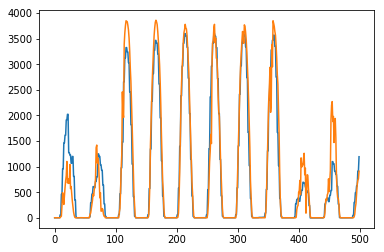

In [72]:
plt.plot(Y_val_pred[0:500])
plt.plot(Y_val_true[0:500])

In [84]:
try:
    predict_data = pd.read_csv('data/predicted_data/predict_train_SOLA0'+str(target_place)+'.tsv', delimiter='\t')

except FileNotFoundError:
    s_idx = result[result['datetime'] == pd.to_datetime('2012/01/02 00:00')].index[0]
    e_idx = result[result['datetime'] == pd.to_datetime('2015/12/31 23:30')].index[0]
    predict_data = pd.DataFrame({"datetime":result['datetime'][s_idx:e_idx+1]})
    predict_data.index = np.arange(len(predict_data))
    predict_data.to_csv('data/predicted_data/predict_train_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)

In [85]:
# 学習済みmodelを書き出す(train)
for i in range(n_splits):
    i+=1
    model_name = 'target_place_'+str(target_place)+'_svr_C_'+str(C)+'_e_'+str(epsilon)+'_'+str(i)+'-5folds'
    svr = joblib.load('data/model/'+model_name+'.pkl') 

    Y_train_pred = svr.predict(input_list)
    Y_train_pred = denormalize_array(Y_train_pred, kwh_min, kwh_max)
    # Y_train_true = denormalize_array(Y_train, kwh_min, kwh_max)

#     Y_val_pred = svr.predict(X_val)
#     Y_val_pred = denormalize_array(Y_val_pred, kwh_min, kwh_max)
#     Y_val_true = denormalize_array(Y_val, kwh_min, kwh_max)

    # print("train mae :", np.abs(Y_train_pred - Y_train_true).mean())
#     print("validation mae : ", np.abs(Y_val_pred - Y_val_true).mean())
    
    predict_data[model_name] = Y_train_pred[48:]
    predict_data.to_csv('data/predicted_data/predict_train_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)

In [86]:
try:
    predict_data = pd.read_csv('data/predicted_data/predict_SOLA0'+str(target_place)+'.tsv', delimiter='\t')

except FileNotFoundError:
    s_idx = result[result['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
    e_idx = result[result['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
    predict_data = pd.DataFrame({"datetime":result['datetime'][s_idx:e_idx+1]})
    predict_data.index = np.arange(len(predict_data))
    predict_data.to_csv('data/predicted_data/predict_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)

In [87]:
# 学習済みmodelを書き出す(predict)
for i in range(n_splits):
    i+=1
    model_name = 'target_place_'+str(target_place)+'_svr_C_'+str(C)+'_e_'+str(epsilon)+'_'+str(i)+'-5folds'
    svr = joblib.load('data/model/'+model_name+'.pkl') 

    Y_test_pred = svr.predict(X_test)
    Y_test_pred = denormalize_array(Y_test_pred, kwh_min, kwh_max)
    
    predict_data[model_name] = Y_test_pred
    predict_data.to_csv('data/predicted_data/predict_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)

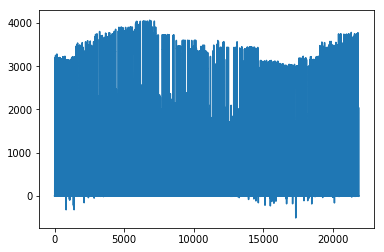

In [59]:
plt.plot(Y_test_pred)

### **rbfカーネル**

In [88]:
# rbfにおける最適なepsilonを探す
C = 3
t_maes = []
v_maes = []
epsilons = [0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]
for epsilon in epsilons:
    svr = SVR(C=C, epsilon=epsilon, kernel="rbf")
    svr.fit(X_train, Y_train) 

    Y_train_pred = svr.predict(X_train)
    Y_train_pred = denormalize_array(Y_train_pred, kwh_min, kwh_max)
    Y_train_true = denormalize_array(Y_train, kwh_min, kwh_max)

    Y_val_pred = svr.predict(X_val)
    Y_val_pred = denormalize_array(Y_val_pred, kwh_min, kwh_max)
    Y_val_true = denormalize_array(Y_val, kwh_min, kwh_max)
    
    t_maes.append(np.abs(Y_train_pred - Y_train_true).mean())
    v_maes.append(np.abs(Y_val_pred - Y_val_true).mean())
#     print("train_mae : ", np.abs(Y_train_pred - Y_train_true).mean())
#     print("val_mae : ", np.abs(Y_val_pred - Y_val_true).mean())

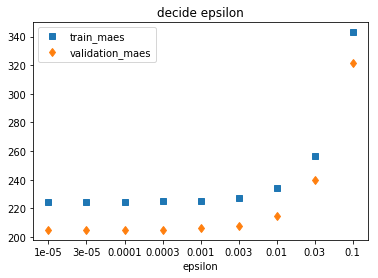

In [89]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.xticks(np.arange(len(epsilons)), epsilons)
plt.xlabel("epsilon")
plt.title("decide epsilon")
plt.legend()

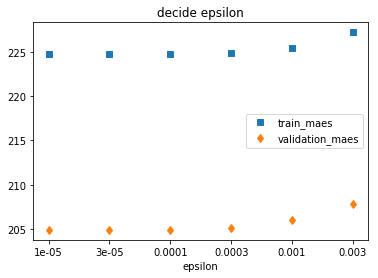

In [91]:
plt.plot(t_maes[:-3], 's', label="train_maes")
plt.plot(v_maes[:-3], 'd', label="validation_maes")
plt.xticks(np.arange(len(epsilons)-3), epsilons[:-3])
plt.xlabel("epsilon")
plt.title("decide epsilon")
plt.legend()

In [98]:
# 最適なCを決めたい(続く)
Cs = [0.1, 0.3, 1, 3, 10]
t_maes = []
v_maes = []
for C in Cs:
    svr = SVR(C=C, epsilon=0.0003)
    svr.fit(X_train, Y_train) 

    Y_train_pred = svr.predict(X_train)
    Y_train_pred = denormalize_array(Y_train_pred, kwh_min, kwh_max)
    Y_train_true = denormalize_array(Y_train, kwh_min, kwh_max)

    Y_val_pred = svr.predict(X_val)
    Y_val_pred = denormalize_array(Y_val_pred, kwh_min, kwh_max)
    Y_val_true = denormalize_array(Y_val, kwh_min, kwh_max)
    
    t_maes.append(np.abs(Y_train_pred - Y_train_true).mean())
    v_maes.append(np.abs(Y_val_pred - Y_val_true).mean())
#     print("train_mae : ", np.abs(Y_train_pred - Y_train_true).mean())
#     print("val_mae : ", np.abs(Y_val_pred - Y_val_true).mean())

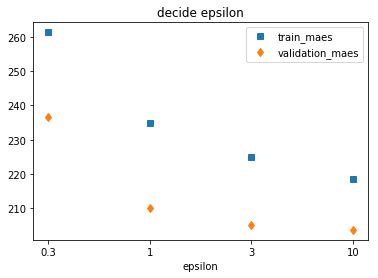

In [100]:
plt.plot(t_maes[1:], 's', label="train_maes")
plt.plot(v_maes[1:], 'd', label="validation_maes")
plt.xticks(np.arange(len(Cs[1:])), Cs[1:])
plt.xlabel("epsilon")
plt.title("decide epsilon")
plt.legend()

### **C =10, epsilon = 0.0003が最適としておきます**

In [101]:
# 交差検証
t_maes = []
v_maes = []

n_splits = 5
C = 10
epsilon = 0.0003
i = 0
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    
    X_train = X[train_idx]
    Y_train = Y[train_idx]
    X_val = X[test_idx]
    Y_val = Y[test_idx]
    
    svr = SVR(C=C, epsilon=epsilon, kernel = "rbf")
    svr.fit(X_train, Y_train)
    
    i += 1
    model_name = "target_place_"+str(target_place)+"_svr_rbf_C_"+str(C)
    model_name +="_e_"+str(epsilon)+"_"+str(i)+"-"+str(n_splits)+"folds"
    model_name += ".pkl"
    
    Y_train_pred = svr.predict(X_train)
    Y_train_pred = denormalize_array(Y_train_pred, kwh_min, kwh_max)
    Y_train_true = denormalize_array(Y_train, kwh_min, kwh_max)

    Y_val_pred = svr.predict(X_val)
    Y_val_pred = denormalize_array(Y_val_pred, kwh_min, kwh_max)
    Y_val_true = denormalize_array(Y_val, kwh_min, kwh_max)
    
    joblib.dump(svr, "data/model/"+model_name) 
    
    t_maes.append(np.abs(Y_train_pred - Y_train_true).mean())
    v_maes.append(np.abs(Y_val_pred - Y_val_true).mean())
    
    print(str(i)+"-"+str(n_splits)+" folds")
    print("train mae :", np.abs(Y_train_pred - Y_train_true).mean())
    print("validation mae : ", np.abs(Y_val_pred - Y_val_true).mean())
    print()

1-5 folds
train mae : 207.599064326
validation mae :  269.186026405

2-5 folds
train mae : 224.910970057
validation mae :  188.822298313

3-5 folds
train mae : 202.812841532
validation mae :  280.843564165

4-5 folds
train mae : 206.304007775
validation mae :  255.941687737

5-5 folds
train mae : 218.594730641
validation mae :  203.699860603



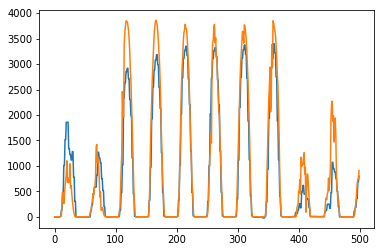

In [102]:
plt.plot(Y_val_pred[0:500])
plt.plot(Y_val_true[0:500])

In [103]:
try:
    predict_data = pd.read_csv('data/predicted_data/predict_train_SOLA0'+str(target_place)+'.tsv', delimiter='\t')

except FileNotFoundError:
    s_idx = result[result['datetime'] == pd.to_datetime('2012/01/02 00:00')].index[0]
    e_idx = result[result['datetime'] == pd.to_datetime('2015/12/31 23:30')].index[0]
    predict_data = pd.DataFrame({"datetime":result['datetime'][s_idx:e_idx+1]})
    predict_data.index = np.arange(len(predict_data))
    predict_data.to_csv('data/predicted_data/predict_train_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)

In [104]:
# 学習済みmodelを書き出す(train)
for i in range(n_splits):
    i+=1
    model_name = 'target_place_'+str(target_place)+'_svr_rbf_C_'+str(C)+'_e_'+str(epsilon)+'_'+str(i)+'-5folds'
    svr = joblib.load('data/model/'+model_name+'.pkl') 

    Y_train_pred = svr.predict(input_list)
    Y_train_pred = denormalize_array(Y_train_pred, kwh_min, kwh_max)
    # Y_train_true = denormalize_array(Y_train, kwh_min, kwh_max)

#     Y_val_pred = svr.predict(X_val)
#     Y_val_pred = denormalize_array(Y_val_pred, kwh_min, kwh_max)
#     Y_val_true = denormalize_array(Y_val, kwh_min, kwh_max)

    # print("train mae :", np.abs(Y_train_pred - Y_train_true).mean())
#     print("validation mae : ", np.abs(Y_val_pred - Y_val_true).mean())
    
    predict_data[model_name] = Y_train_pred[48:]
    predict_data.to_csv('data/predicted_data/predict_train_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)

In [105]:
try:
    predict_data = pd.read_csv('data/predicted_data/predict_SOLA0'+str(target_place)+'.tsv', delimiter='\t')

except FileNotFoundError:
    s_idx = result[result['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
    e_idx = result[result['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
    predict_data = pd.DataFrame({"datetime":result['datetime'][s_idx:e_idx+1]})
    predict_data.index = np.arange(len(predict_data))
    predict_data.to_csv('data/predicted_data/predict_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)

In [106]:
# 学習済みmodelを書き出す(predict)
for i in range(n_splits):
    i+=1
    model_name = 'target_place_'+str(target_place)+'_svr_rbf_C_'+str(C)+'_e_'+str(epsilon)+'_'+str(i)+'-5folds'
    svr = joblib.load('data/model/'+model_name+'.pkl') 

    Y_test_pred = svr.predict(X_test)
    Y_test_pred = denormalize_array(Y_test_pred, kwh_min, kwh_max)
    
    predict_data[model_name] = Y_test_pred
    predict_data.to_csv('data/predicted_data/predict_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)

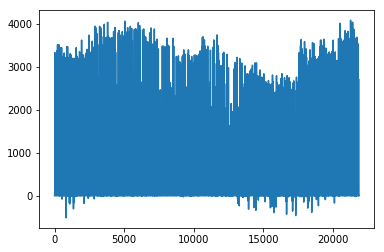

In [107]:
plt.plot(Y_test_pred)

### **rbfのガンマを決めよう**

In [109]:
# rbfにおける最適なepsilonを探す
C = 3
t_maes = []
v_maes = []
epsilons = 0.003
gammas = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
for gamma in gammas:
    svr = SVR(C=C, epsilon=epsilon, kernel="rbf", gamma = gamma)
    svr.fit(X_train, Y_train) 

    Y_train_pred = svr.predict(X_train)
    Y_train_pred = denormalize_array(Y_train_pred, kwh_min, kwh_max)
    Y_train_true = denormalize_array(Y_train, kwh_min, kwh_max)

    Y_val_pred = svr.predict(X_val)
    Y_val_pred = denormalize_array(Y_val_pred, kwh_min, kwh_max)
    Y_val_true = denormalize_array(Y_val, kwh_min, kwh_max)
    
    t_maes.append(np.abs(Y_train_pred - Y_train_true).mean())
    v_maes.append(np.abs(Y_val_pred - Y_val_true).mean())
    print("gamma : ", gamma)
    print("train_mae : ", np.abs(Y_train_pred - Y_train_true).mean())
    print("val_mae : ", np.abs(Y_val_pred - Y_val_true).mean())
    print()

gamma :  0.0001
train_mae :  367.172498929
val_mae :  338.09276817

gamma :  0.0003
train_mae :  340.426225099
val_mae :  321.829771874

gamma :  0.001
train_mae :  330.839467559
val_mae :  312.519758763

gamma :  0.003
train_mae :  305.837805152
val_mae :  283.458944842

gamma :  0.01
train_mae :  243.229826599
val_mae :  217.87802029

gamma :  0.03
train_mae :  220.813270729
val_mae :  204.137414981

gamma :  0.1
train_mae :  206.260486942
val_mae :  204.27148425

gamma :  0.3
train_mae :  188.666016996
val_mae :  223.152416398

gamma :  1
train_mae :  166.665804803
val_mae :  245.177889758

gamma :  3
train_mae :  152.239834968
val_mae :  280.125452085

gamma :  10
train_mae :  138.001827312
val_mae :  352.738491955



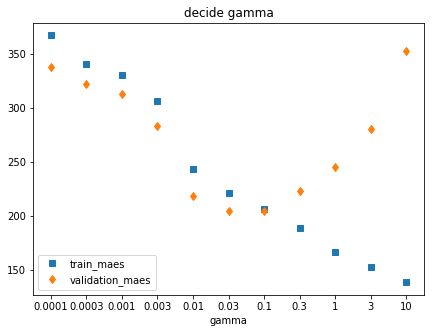

In [113]:
plt.figure(figsize=(7, 5))
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.xticks(np.arange(len(gammas)), gammas)
plt.xlabel("gamma")
plt.title("decide gamma")
plt.legend()

### **C = 3, epsilon = 0.001, gamma = 0.1を最適としておきます**

In [114]:
# 交差検証
t_maes = []
v_maes = []

n_splits = 5
C = 3
epsilon = 0.001
gamma = 0.1
i = 0
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    
    X_train = X[train_idx]
    Y_train = Y[train_idx]
    X_val = X[test_idx]
    Y_val = Y[test_idx]
    
    svr = SVR(C=C, epsilon=epsilon, kernel = "rbf")
    svr.fit(X_train, Y_train)
    
    i += 1
    model_name = "target_place_"+str(target_place)+"_svr_rbf_C_"+str(C)
    model_name +="_e_"+str(epsilon)+"_gamma_"+str(gamma)+"_"+str(i)+"-"+str(n_splits)+"folds"
    model_name += ".pkl"
    
    Y_train_pred = svr.predict(X_train)
    Y_train_pred = denormalize_array(Y_train_pred, kwh_min, kwh_max)
    Y_train_true = denormalize_array(Y_train, kwh_min, kwh_max)

    Y_val_pred = svr.predict(X_val)
    Y_val_pred = denormalize_array(Y_val_pred, kwh_min, kwh_max)
    Y_val_true = denormalize_array(Y_val, kwh_min, kwh_max)
    
    joblib.dump(svr, "data/model/"+model_name) 
    
    t_maes.append(np.abs(Y_train_pred - Y_train_true).mean())
    v_maes.append(np.abs(Y_val_pred - Y_val_true).mean())
    
    print(str(i)+"-"+str(n_splits)+" folds")
    print("train mae :", np.abs(Y_train_pred - Y_train_true).mean())
    print("validation mae : ", np.abs(Y_val_pred - Y_val_true).mean())
    print()

1-5 folds
train mae : 213.166709235
validation mae :  270.679780001

2-5 folds
train mae : 231.035880505
validation mae :  195.993891982

3-5 folds
train mae : 208.884042302
validation mae :  291.511655917

4-5 folds
train mae : 212.826875975
validation mae :  263.089255061

5-5 folds
train mae : 225.433280609
validation mae :  206.01358463



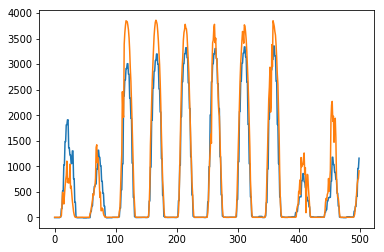

In [115]:
plt.plot(Y_val_pred[0:500])
plt.plot(Y_val_true[0:500])

In [116]:
try:
    predict_data = pd.read_csv('data/predicted_data/predict_train_SOLA0'+str(target_place)+'.tsv', delimiter='\t')

except FileNotFoundError:
    s_idx = result[result['datetime'] == pd.to_datetime('2012/01/02 00:00')].index[0]
    e_idx = result[result['datetime'] == pd.to_datetime('2015/12/31 23:30')].index[0]
    predict_data = pd.DataFrame({"datetime":result['datetime'][s_idx:e_idx+1]})
    predict_data.index = np.arange(len(predict_data))
    predict_data.to_csv('data/predicted_data/predict_train_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)

In [117]:
# 学習済みmodelを書き出す(train)
for i in range(n_splits):
    i+=1
    model_name = 'target_place_'+str(target_place)+'_svr_rbf_C_'+str(C)+"_e_"+str(epsilon)+"_gamma_"+str(gamma)+"_"+str(i)+"-"+str(n_splits)+"folds"
    svr = joblib.load('data/model/'+model_name+'.pkl') 

    Y_train_pred = svr.predict(input_list)
    Y_train_pred = denormalize_array(Y_train_pred, kwh_min, kwh_max)
    # Y_train_true = denormalize_array(Y_train, kwh_min, kwh_max)

#     Y_val_pred = svr.predict(X_val)
#     Y_val_pred = denormalize_array(Y_val_pred, kwh_min, kwh_max)
#     Y_val_true = denormalize_array(Y_val, kwh_min, kwh_max)

    # print("train mae :", np.abs(Y_train_pred - Y_train_true).mean())
#     print("validation mae : ", np.abs(Y_val_pred - Y_val_true).mean())
    
    predict_data[model_name] = Y_train_pred[48:]
    predict_data.to_csv('data/predicted_data/predict_train_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)

In [118]:
try:
    predict_data = pd.read_csv('data/predicted_data/predict_SOLA0'+str(target_place)+'.tsv', delimiter='\t')

except FileNotFoundError:
    s_idx = result[result['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
    e_idx = result[result['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
    predict_data = pd.DataFrame({"datetime":result['datetime'][s_idx:e_idx+1]})
    predict_data.index = np.arange(len(predict_data))
    predict_data.to_csv('data/predicted_data/predict_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)

In [119]:
# 学習済みmodelを書き出す(predict)
for i in range(n_splits):
    i+=1
    model_name = 'target_place_'+str(target_place)+'_svr_rbf_C_'+str(C)+"_e_"+str(epsilon)+"_gamma_"+str(gamma)+"_"+str(i)+"-"+str(n_splits)+"folds"
    svr = joblib.load('data/model/'+model_name+'.pkl') 

    Y_test_pred = svr.predict(X_test)
    Y_test_pred = denormalize_array(Y_test_pred, kwh_min, kwh_max)
    
    predict_data[model_name] = Y_test_pred
    predict_data.to_csv('data/predicted_data/predict_SOLA0'+str(target_place)+'.tsv', sep = '\t', index=False)

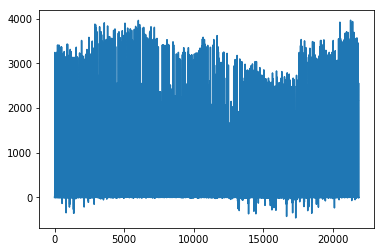

In [120]:
plt.plot(Y_test_pred)

In [59]:
C = 0.1
epsilon = 0.001
svr = SVR(C=C, epsilon=epsilon, kernel="poly", degree=3)
svr.fit(X_train, Y_train) 

Y_train_pred = svr.predict(X_train)
Y_train_pred = denormalize_array(Y_train_pred, kwh_min, kwh_max)
Y_train_true = denormalize_array(Y_train, kwh_min, kwh_max)

Y_val_pred = svr.predict(X_val)
Y_val_pred = denormalize_array(Y_val_pred, kwh_min, kwh_max)
Y_val_true = denormalize_array(Y_val, kwh_min, kwh_max)

print("train_mae : ", np.abs(Y_train_pred - Y_train_true).mean())
print("val_mae : ", np.abs(Y_val_pred - Y_val_true).mean())

train_mae :  669.616521403
val_mae :  560.938476063


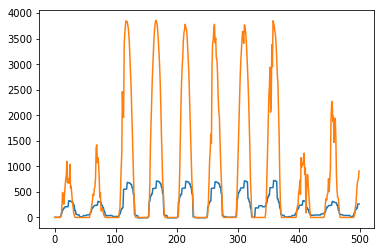

In [60]:
plt.plot(Y_val_pred[0:500])
plt.plot(Y_val_true[0:500])

### **パラメータチューニングすれば可能性を感じなくもない**
**train, valの分かれ方が偶然簡単だった説はある**